In [ ]:
%%html
<!--
<style>
.CodeMirror { width: 100vw; }
.prompt  { visibility: hidden; width: 0px !important; }
.prompt_container { visibility: hidden; width: 0px !important; }
.container {  width: 95% !important; }
.rendered_html { font-size:0.8em; }
.rendered_html table, .rendered_html th, .rendered_html tr, .rendered_html td { font-size: 100%;}
td { font-size: 16px }
</style>
-->

In [ ]:
import schemdraw
import schemdraw.logic as logic
import schemdraw.elements as elm

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

![](https://i.imgur.com/xyqpqh0.png)


![](https://i.imgur.com/VVl1WOW.jpg)


In [ ]:
# class Bit:
#   counter = 0
  
#   @classmethod
#   def uid(cls):
#     cls.counter +=1
#     return f"t_{cls.counter}"

#   def __init__(self,label = None): 
#     self.label = self.uid() if label is None else label
#     self.program = tuple([self.label])
  
#   def op(self,oper, *others):
#     operands = [self, *others]
#     out = Bit()
#     out.program = tuple([oper, *[bit.program for bit in operands]])
#     return out

#   def __and__(self,other): return self.op("∧", other)
#   def __or__(self,other): return self.op("∨", other)
#   def __invert__(self): return self.op("¬")
  
#   def __repr__(self): return f"Bit{self.program}"

# def bits(n):
#   return [Bit(f"X[{i}]") for i in range(n)]

# Some examples

In [ ]:
def lsb(x): return x & 1

In [188]:
a = 1 
b = 0
c = a|b
c

1

In [ ]:
class Bit:
    """Keeps track of operations that are done to it"""
 
    def __init__(self, program):
        self.program = program if isinstance(program,tuple) else (program,)
  
    def op(self,oper, other = None):
        if other is None:
            return Bit((oper,self.program))
        return Bit((oper,self.program,other.program))
        
    def __and__(self,other): return self.op("∧", other)
    def __or__(self,other): return self.op("∨", other)
    def __invert__(self): return self.op("¬")
  
    def __repr__(self): return f"Bit{self.program}"

In [190]:
a = Bit("X[0]")
b = Bit("X[1]")
(a|b).program

('∨', ('X[0]',), ('X[1]',))

# Utilities

Skip all of these in first reading

In [ ]:
def bits(n):
    return [Bit(f"X[{i}]") for i in range(n)]

In [ ]:
def p2f(P):
  """Recursive function to transform a program of a Bit into a formula"""
  if len(P)==1:
    return P[0]
  if len(P)==2:
    return P[0] + p2f(P[1])
  if len(P)==3:
    return f"({p2f(P[1])} {P[0]} {p2f(P[2])})"
  return f"{P[0]}("+",".join([p2f(P[i]) for i in range(1,len(P))])+")"



In [ ]:
counter = 0
def AON_(P):
    """Recursive function to transform a program of a bit into an AON straightline program"""
    def uid():
        global counter
        counter +=1
        return f"z_{counter}"
    funcs = {"∧": "AND", "∨": "OR", "¬": "NOT" }
    if len(P)==1:
        return "",P[0]
    op = funcs[P[0]]  
    if len(P)==2:
        prog, out_ = AON_(P[1])
        out = uid() 
        return prog+f"{out} = {op}({out_})\n", out
    if len(P)==3:
        prog1,out1 = AON_(P[1])
        prog2,out2 = AON_(P[2])
        out = uid()
        return prog1+prog2+f"{out} = {op}({out1},{out2})\n", out

In [ ]:
def AON(f):
    """Take either a function or a bit and return the AON program"""
    global counter
    counter = 0
    if isinstance(f,Bit):
        P = f.program
    else:
        n = len(signature(f).parameters)
        P = f(*bits(n)).program
    prog, out = AON_(P)
    return prog.replace(out,"Y[0]")

In [ ]:
def formula(f):
    """Take either a function or a bit and return the AON program"""
    if isinstance(f,Bit):
        return Math(p2f(f.program))
    n = len(signature(f).parameters)
    F = p2f(f(*bits(n)).program)
    return Math(F)

In [ ]:
def circuit_(P, d : schemdraw.Drawing , dx=0, dy=0, drawn = {}):
  """Recursive function to draw a circuit. Gets the Bit bit and outputs the circuit used to compute it"""
  if P in drawn:
    return drawn[P]
  maxx = dx
  maxy = dy
  outs = []
  gates = { "∧" : logic.And, "∨" : logic.Or, "¬": logic.Not } 
  for c in P[1:]:
    dx_ , dy_ , out = circuit_(c,d,dx,dy ,drawn)
    outs.append(out)
    maxx = max(dx_,maxx)
    maxy = max(dy_,maxy)
    dy = dy_ + 1
  maxx += 2
  x,y = maxx,maxy
  gate = gates[P[0]] if P[0] in gates else logic.Dot
  g = gate(at = (x,y))
  if isinstance(g, logic.Dot):
    g.label(f"{P[0]}")
  d += g
  for i,out in enumerate(outs):
    loc = getattr(g,f"in{i+1}") 
    d += logic.Wire().at(out).to(loc)  
  drawn[P] =  x,y, g.out if hasattr(g,"out") else (x,y)
  return drawn[P]

def draw_circ(*Ys):
  drawn = {}
  dx,dy = 0,0
  with schemdraw.Drawing() as d:
    d.config(unit=0.5)
    for i,y in enumerate(Ys):
      label= f"$Y[{i}]$"
      x,dy_, out = circuit_(y.program,d,dx,dy, drawn)
      d += logic.Dot().at(out).label(label)
      dy = dy_+2


In [ ]:
import itertools
from IPython.display import Markdown, display, Math
from inspect import signature

def table(f,n=None):
  """Generate truth table of a function"""
  if n is None:
    n = len(signature(f).parameters)
  m = max(n+2,len(f.__name__)+4)
  res = "x".ljust(m) + " | " + f"{f.__name__}(x)".ljust(m) 
  res += "\n" + "-"*m+"-|-"+ "-"*m 
  
  for x in itertools.product([0,1],repeat=n):
    s = "".join([str(c) for c in x])
    res += "\n"+ s.ljust(m) + " | " + str(f(*x)).ljust(m)
  res +="\n"
  return Markdown(res)

In [ ]:
def circuit(f,n=None):
    """Take a function or a bit and output circuit"""
    if isinstance(f,Bit):
        res = f
    else:
        if n is None:
            n = len(signature(f).parameters)
        res = f(*bits(n))
    return draw_circ(*res) if isinstance(res,(tuple,list)) else draw_circ(res)

# End of utilities

In [193]:
a = Bit("X[0]")
b = Bit("X[1]")
c = a & b
~c 

Bit('¬', ('∧', ('X[0]',), ('X[1]',)))

In [194]:
d = Bit("X[2]")
e = ~(d | c)
e

Bit('¬', ('∨', ('X[2]',), ('∧', ('X[0]',), ('X[1]',))))

In [195]:
formula(e)

<IPython.core.display.Math object>

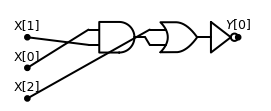

In [196]:
circuit(e)

### XOR

In [197]:
def XOR(a,b):
    return (a & ~b) | (~a & b)

In [199]:
XOR(1,1)

0

In [200]:
table(XOR)

x       | XOR(x) 
--------|--------
00      | 0      
01      | 1      
10      | 1      
11      | 0      


In [201]:
XOR(Bit("X[0]"),Bit("X[1]"))

Bit('∨', ('∧', ('X[0]',), ('¬', ('X[1]',))), ('∧', ('¬', ('X[0]',)), ('X[1]',)))

In [202]:
formula(XOR)

<IPython.core.display.Math object>

In [203]:
AON(XOR)

'z_1 = NOT(X[1])\nz_2 = AND(X[0],z_1)\nz_3 = NOT(X[0])\nz_4 = AND(z_3,X[1])\nY[0] = OR(z_2,z_4)\n'

In [204]:
print(AON(XOR))

z_1 = NOT(X[1])
z_2 = AND(X[0],z_1)
z_3 = NOT(X[0])
z_4 = AND(z_3,X[1])
Y[0] = OR(z_2,z_4)



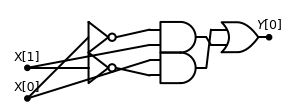

In [205]:
circuit(XOR)

### Composition

In [206]:
def XOR4(a,b,c,d):
    return XOR(XOR(a,b),XOR(c,d))

In [207]:
formula(XOR4)

<IPython.core.display.Math object>

In [208]:
print(AON(XOR4))

z_1 = NOT(X[1])
z_2 = AND(X[0],z_1)
z_3 = NOT(X[0])
z_4 = AND(z_3,X[1])
z_5 = OR(z_2,z_4)
z_6 = NOT(X[3])
z_7 = AND(X[2],z_6)
z_8 = NOT(X[2])
z_9 = AND(z_8,X[3])
z_10 = OR(z_7,z_9)
z_11 = NOT(z_10)
z_12 = AND(z_5,z_11)
z_13 = NOT(X[1])
z_14 = AND(X[0],z_13)
z_15 = NOT(X[0])
z_16 = AND(z_15,X[1])
z_17 = OR(z_14,z_16)
z_18 = NOT(z_17)
z_19 = NOT(X[3])
z_20 = AND(X[2],z_19)
z_21 = NOT(X[2])
z_22 = AND(z_21,X[3])
z_23 = OR(z_20,z_22)
z_24 = AND(z_18,z_23)
Y[0] = OR(z_12,z_24)



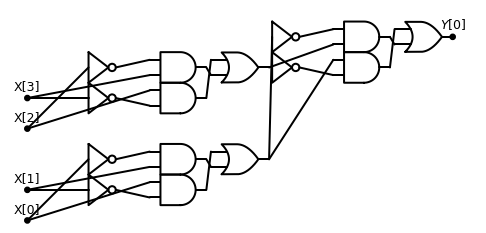

In [209]:
circuit(XOR4)

In [ ]:
def MAJ(a,b,c):
    return (a&b) | (b&c) | (a&c)

In [ ]:
table(MAJ)

In [ ]:
formula(MAJ)

In [ ]:
circuit(MAJ)

In [ ]:
def add(a,b):
    return XOR(a,b), a&b

In [ ]:
circuit(add)

# Parsing programs

In [ ]:
import re
def parse(P):
    """Take an AON program and split each line into components"""
    result  = []
    for line in P.split('\n'):
        split = re.split("=|\(|\)|,| ",line) 
        split = [x for x in split if x != ""]
        if split:
            result.append(split)
    return result
 

In [210]:
parse(AON(XOR))

[['z_1', 'NOT', 'X[1]'],
 ['z_2', 'AND', 'X[0]', 'z_1'],
 ['z_3', 'NOT', 'X[0]'],
 ['z_4', 'AND', 'z_3', 'X[1]'],
 ['Y[0]', 'OR', 'z_2', 'z_4']]

In [211]:
def evalp(tuples,x):
    """Evaluate a parsed program on an input"""
    variables = { f"X[{i}]":x[i] for i in range(len(x)) }
    for rhs,op,*oper in tuples:
        print(f"Evaluating {rhs} = {op}({','.join(oper)}):\t variables = {variables}")
        oper = [variables[o] for o in oper]
        if op=="NOT":
            variables[rhs] = 1 - oper[0]
        elif op=="AND":
            variables[rhs] = oper[0]*oper[1]
        elif op=="OR":
            variables[rhs] = 1 - (1-oper[0])*(1-oper[1])
    return variables["Y[0]"]

In [212]:
aon = parse(AON(XOR))
print(AON(XOR))

z_1 = NOT(X[1])
z_2 = AND(X[0],z_1)
z_3 = NOT(X[0])
z_4 = AND(z_3,X[1])
Y[0] = OR(z_2,z_4)



In [214]:
evalp(aon,[1,1])

Evaluating z_1 = NOT(X[1]):	 variables = {'X[0]': 1, 'X[1]': 1}
Evaluating z_2 = AND(X[0],z_1):	 variables = {'X[0]': 1, 'X[1]': 1, 'z_1': 0}
Evaluating z_3 = NOT(X[0]):	 variables = {'X[0]': 1, 'X[1]': 1, 'z_1': 0, 'z_2': 0}
Evaluating z_4 = AND(z_3,X[1]):	 variables = {'X[0]': 1, 'X[1]': 1, 'z_1': 0, 'z_2': 0, 'z_3': 0}
Evaluating Y[0] = OR(z_2,z_4):	 variables = {'X[0]': 1, 'X[1]': 1, 'z_1': 0, 'z_2': 0, 'z_3': 0, 'z_4': 0}


0

[tiny.cc/areyouhere](https://tiny.cc/areyouhere)

# Digression: Neural networks and pytorch


![](https://i.imgur.com/JbPlJlM.png)

![](https://i.imgur.com/pG0RixM.png)

![](https://i.imgur.com/DXAO5vi.png)


In [ ]:
import torch

In [215]:
import torch
a = torch.tensor([0.5], requires_grad=True)
b = torch.tensor([2.0], requires_grad=True)
a*b

tensor([1.], grad_fn=<MulBackward0>)

In [ ]:
def t2f(fn):
    if isinstance(fn,torch.Tensor):
        fn = fn._grad_fn
    ops = [t2f(x) for x,_ in fn.next_functions]
    name = str(fn.__class__)
    i = name.find("'")
    j = name[i+1:].find("'")+i+1
    name = name[i+1:j]
    if not ops:
        return name
    return name+"("+ ",".join(ops) +")"
    

In [216]:
t2f( (a+b)*(a+b))

'MulBackward0(AddBackward0(AccumulateGrad,AccumulateGrad),AddBackward0(AccumulateGrad,AccumulateGrad))'

In [217]:
c = torch.log(a*b)
t2f(c)

'LogBackward0(MulBackward0(AccumulateGrad,AccumulateGrad))'

In [ ]:
# Adaptation of gist https://gist.github.com/OniDaito/f5bfb83b6677835219feeb95ddb1e4ad 


# Our drawing graph functions. We rely / have borrowed from the following
# python libraries:
# https://github.com/szagoruyko/pytorchviz/blob/master/torchviz/dot.py
# https://github.com/willmcgugan/rich
# https://graphviz.readthedocs.io/en/stable/


def draw_graph(start, watch=[]):
    from graphviz import Digraph

    node_attr = dict(style='filled',
                     shape='box',
                     align='left',
                     fontsize='12',
                     ranksep='0.1',
                     height='0.2')
    graph = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12"))

    assert(hasattr(start, "grad_fn"))
    if start.grad_fn is not None:
        o = lambda a: None
        o.next_functions = [(start.grad_fn,0)]
        _draw_graph(o, graph, watch=watch)

    size_per_element = 0.15
    min_size = 12

    # Get the approximate number of nodes and edges
    num_rows = len(graph.body)
    content_size = num_rows * size_per_element
    size = max(min_size, content_size)
    size_str = str(size) + "," + str(size)
    graph.graph_attr.update(size=size_str)
    graph.render(filename='net_graph.jpg')
    return graph


def _draw_graph(var, graph, watch=[], seen=[], indent="", pobj=None):
    ''' recursive function going through the hierarchical graph printing off
    what we need to see what autograd is doing.'''
    #from rich import print
    
    if hasattr(var, "next_functions"):
        for fun in var.next_functions:
            joy = fun[0]
            if joy is not None:
                if True or joy not in seen:
                    label = str(type(joy)).replace(
                        "class", "").replace("'", "").replace(" ", "")
                    label_graph = label
                    colour_graph = ""
                    seen.append(joy)

                    if hasattr(joy, 'variable'):
                        happy = joy.variable
                        if happy.is_leaf:
                            label += " \U0001F343"
                            colour_graph = "green"

                            for (name, obj) in watch:
                                if obj is happy:
                                    label += " \U000023E9 " + \
                                        "[b][u][color=#FF00FF]" + name + \
                                        "[/color][/u][/b]"
                                    label_graph += name
                                    
                                    colour_graph = "blue"
                                    break

                                vv = [str(obj.shape[x]) for x in range(len(obj.shape))]
                                label += " [["
                                label += ', '.join(vv)
                                label += "]]"
                                label += " " + str(happy.var())

                    graph.node(str(joy), label_graph, fillcolor=colour_graph)
                    #print(indent + label)
                    _draw_graph(joy, graph, watch, seen, indent + ".", joy)
                    if pobj is not None:
                        graph.edge(str(pobj), str(joy))

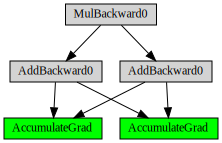

In [218]:
draw_graph((a+b)*(a+b))

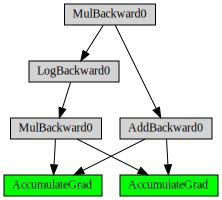

In [220]:
draw_graph(c*(a+b))

Move to powerpoint